
---

## 15 - FEC First Principles
Forward Error Correction (FEC) is a method used to detect and correct errors in digital communication systems. The goal of FEC is to enable the receiver to correct errors that occur during the transmission of data without the need for retransmission. One type of FEC, known as Soft Decision FEC (SD-FEC), utilises soft information about the received signal to make more accurate error correction decisions. Soft information refers to the likelihood of a bit being a 1 or 0 before decoding. This information is represented as a real value, typically between -infinity and infinity, and is used by decoding algorithms such as Viterbi and Sum-Product (min-sum) to make decisions on the most likely value of a bit. The larger the value, the more likely the bit is a 1, while the smaller the value, the more likely the bit is a 0. The term "soft" is used to contrast it with "hard" decisions, where a bit is simply assigned a value of 1 or 0 based on a threshold.

Low Density Parity Check (LDPC) codes are a specific type of FEC codes that have gained popularity due to their ability to achieve near Shannon limit performance. LDPC codes are linear block codes that can be represented by a sparse parity-check matrix, which makes them well-suited for hardware implementations. They are also highly flexible and can be adapted to suit a wide range of channel conditions.

This series of notebooks will explore the use of SD-FEC on RFSoC and how to use the integrated blocks on the RFSoC device to perform LDPC encoding and decoding. We will investigate a simplified radio pipeline that performs baseband modulation and demodulation into soft bits after being subjected to an AWGN channel. Additionally, we will introduce the performance measure BER and demonstrate how it can be used to assess and compare code performance by generating BER curves. While we will focus solely on LDPC codes to demonstrate encoding and decoding, it is worth noting that the SD-FEC blocks can also be used for Turbo decoding. 

## Table of Contents
* [1. Introduction](#introduction)
* [2. LDPC Coding](#nb1_ldpc_coding)
    * [2.1. Parity Check Matrices](#nb1_parity)
    * [2.2. Encoding](#nb1_encoding)
    * [2.3. Decoding](#nb1_decoding)
* [3. Code Definition File](#nb1_code_definition)
* [4. Conclusion](#nb1_conclusion)

## References
* [1] - [AMD-Xilinx, "Soft-Decision FEC Integrated Block v1.1: LogiCORE IP Product Guide", October 2022](https://docs.xilinx.com/r/en-US/pg256-sdfec-integrated-block)



---


## 1. Introduction <a class="anchor" id="nb1_ldpc_coding"></a>
This notebook will discuss some key terms and how the SD-FEC core performs encoding and decoding using LDPC codes. The aim is to provide introductory context before using the SD-FEC blocks found on RFSoC devices directly.

## 2. LDPC Coding <a class="anchor" id="nb1_ldpc_coding"></a>
LDPC codes are a type of error-correcting code that can be used for forward error correction. They are created by specifying the parity-check matrix of the code, which is a sparse matrix that defines the constraint equations that the codeword must satisfy. The parity-check matrix is typically designed using a variety of techniques such as density evolution, linear programming, or random constructions. Once the parity-check matrix is determined, the generator matrix can be obtained using a technique known as Gaussian elimination. Often, the generator matrix is used to encode the data and the parity-check matrix is used to decode the data. With these matrices, one can encode and decode messages.

### 2.1. Parity Check Matrices <a class="anchor" id="nb1_parity"></a>
A parity check matrix is a fundamental component of Low-Density Parity-Check (LDPC) codes in channel coding. It is used to define the structure of the code and the relationships between the code bits and the parity bits. The parity check matrix is a sparse matrix that defines the constraints on the code bits that are necessary to ensure that the code is a valid one. The rows of the matrix represent the parity bits, while the columns represent the code bits. Each entry in the matrix is a binary value (0 or 1) that represents whether or not the corresponding code bit is involved in the constraint of the corresponding parity bit. The parity check matrix is used in the encoding process to check whether the code bits satisfy the constraints defined by the matrix, and in the decoding process to find the most likely values of the code bits.

### 2.2. Encoding <a class="anchor" id="nb1_encoding"></a>
While a generator matrix is often used to encode data, the SD-FEC blocks perform encoding using the parity check matrix. This is acheived by transforming the parity check matrix into a new matrix that comprises two parts: a systematic part (*H1*) and a parity part (*H2*). The parity component of the matrix must be in lower triangular form and the encoder can support both single and double diagonals or indeed a double diagonal followed by a single diagonal as adopted by 5G wireless. 

<a class="anchor" id="fig-1"></a>
<center><figure>
<img src='../img/lower_triangle.svg' width='450'/>
    <figcaption><b>Figure 1: H matrix, reduced to lower triangular form.</b></figcaption>
</figure></center>

### 2.3. Decoding <a class="anchor" id="nb1_decoding"></a>
When decoding, the SD-FEC block employs the normalised min-sum algorithm. Min-sum decoding is a low-complexity decoding algorithm for LDPC codes. It is based on the belief propagation algorithm, which is used to decode error-correcting codes on a Tanner graph. In this algorithm, each variable node (corresponding to a code bit) and each check node (corresponding to a parity bit) represents a vertex in the graph. Each edge in the graph represents a constraint between a code bit and a parity bit. The Min-sum algorithm iteratively updates the beliefs of the variable nodes based on the beliefs of the check nodes and the channel likelihoods.

In each iteration, the algorithm performs the following steps:

1. For each check node, it calculates the minimum sum of the incoming messages from the neighboring variable nodes, and sends this value as a message to its neighboring variable nodes.
2. For each variable node, it calculates the sum of the incoming messages from the neighboring check nodes, and the log-likelihood ratio (LLR) of the channel output. It then updates its belief as the sum of these values, and sends this value as a message to its neighboring check nodes.

The algorithm stops when the beliefs of the variable nodes converge to the correct codeword or a maximum number of iterations is reached. The Min-sum algorithm is known to be suboptimal, meaning that the final beliefs of the variable nodes may not converge to the correct codeword, but it is still a useful decoding algorithm due to its low complexity.

## 3. Code Definition File <a class="anchor" id="nb1_code_definition"></a>
The SD-FEC block supports a number of standards: 5G, LTE, Wifi 802.1, and DOCSIS 3.1. These standards provide a variety of LDPC codes. Additionally, users are able to supply their own custom LDPC codes. This is facilited through a *code definition file* which is a YAML formatted file that must have a \*.txt file extension. The code definition file can be constructed using an LDPC code's parity check matrix. In the following code cells we will take the DOCSIS Initial Ranging parity check matrix as an example to illustrate how to generate a code definition file.

First we will load the parity check matrix from a \*.csv file and inspect some parameters.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf

with open('./data/docsis_init_ranging_parity.csv') as f:
    H = np.loadtxt(f, delimiter=",")
    
n = H.shape[1] # block size (parity check columns)
k = H.shape[0] # information bits (parity check rows)
p = 16         # sub-matrix size

print('Block Size (bits):',n)
print('Information Bits:',k)
print('Sub-Matrix Size:',p)

Block Size (bits): 160
Information Bits: 80
Sub-Matrix Size: 16


We can use this information to plot our parity check matrix.

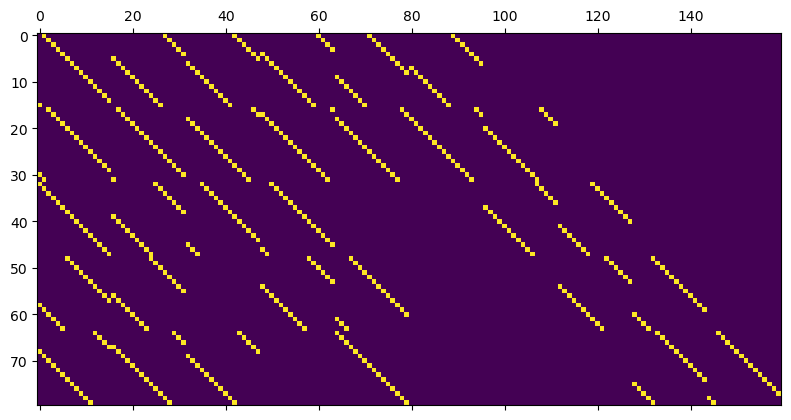

In [5]:
#hf.plot_parity_check_matrix('DOCSIS Init. Ranging Parity Check Matrix',H,p)
plt.matshow(H)

The code definition file must contain: the encoded block size, *n*; the input block size which contains the information bits, *k*; the sub-matrix size, *p*; and the base matrix definition, *sm_array*, which itself must contain a list of row, column, and shift values. 

Some of these parameters can be taken directly and input to the YAML. Others need to be derived. From the parity check matrix plotted in the previous cell, we can see that the sub-matrices are either all-zero matrices or cyclically right-shifted identity matrices. We assemble the *sm_array* parameter by taking only the sub-matrices that contain an identity matrix and provide their row and column numbers as well as the number of right shifts undergone by the identity matrix. 

The code below performs this process and prints out the LDPC parameters in YAML format.

In [ ]:
print('docsis_init_ranging:')
print('  n:', n)
print('  k:', k)
print('  p:', p)
print('  sm_array:')
for row_i in range(k)[::p]:
    for col_i in range(n)[::p]:
        sm_row = row_i/p
        sm_col = col_i/p
        sm_row_0 = H[row_i,col_i:col_i+p]
        shift = np.where(sm_row_0==1)
        if shift[0].size > 0: # If there is a sub matrix
            print('  - {row: %d, col: %d, shift: %d}' % (sm_row, sm_col, shift[0][0]))

## 4. Conclusion <a class="anchor" id="nb1_conclusion"></a>
This notebook has introduced some key terms relating to soft decision forward error correction and shown how parity check matrices can be formatted for use by the SD-FEC blocks. 

---

[⬅️ Previous Notebook](14_frequency_planning.ipynb) || [Next Notebook 🚀](16_fec_channel_simulation.ipynb)

---